# Notebook Project 2 Spatio temporele modellen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

## Hypothetisch terein 

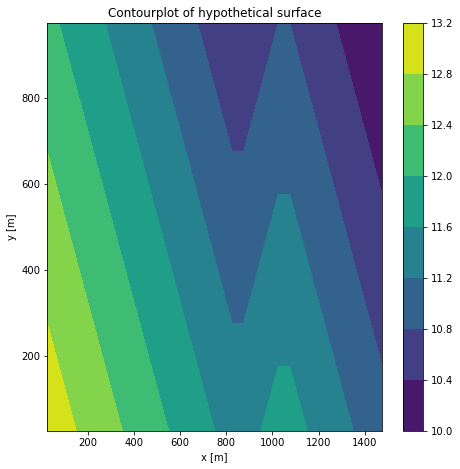

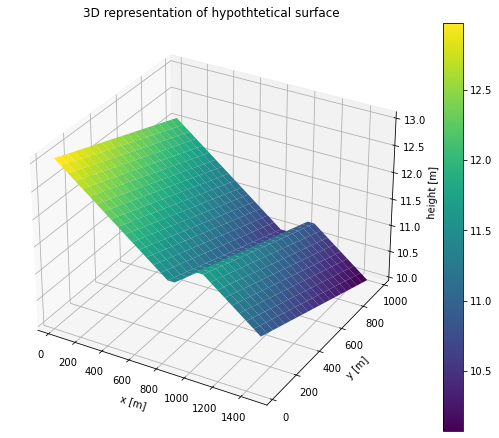

In [2]:
runfile('Grid_hypoth.py')
deltax = 50
deltay = 50
#geeft ons deze figuren en het grid dat we nodig hebben als grid
#convectie: grid[y,x] om zo met contour functies te kunnen werken!

Grid zoals hierboven aangemaakt is ZONDER de randen die nodig zijn om de randcondities te voldoen. Hiervoor bij alle niet outflowcellen een hoge waarde van hoogte om outflow te vermijden. Bij de outflowcel moet de gradient verder worden gevolgd voor continuiteit

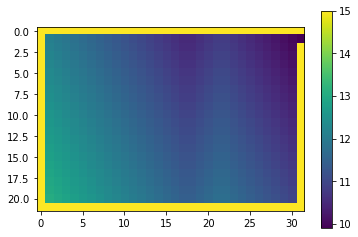

In [3]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = 15
grid_imag[:-1,-1] = 15
grid_imag[-2,-1] = grid[-1,-1] - (slopex*deltax) #dus wegdraineren met zelfde gradient
grid_imag[0,:] = 15
grid_imag[-1,:] = 15
plt.imshow(np.flipud(grid_imag))
plt.colorbar()

De ene outflow wordt dus duidelijk hier.

## De lokale loop over een neigbourhood

Huidige idee van de implementatie:
* ken een kleine waterdiepte toe om te starten (bv. 1 mm = 0.001m)
* bereken de maximale snelheid obv formule (6)
* bereken de $\Delta t$ via formule (7)
* bepaal nu hoeveel regent er valt met deze $\Delta t$
* start de de NH loop, waarin $v^*$ wordt berekend. Als deze groter is dan $v$, dan wordt $F$ herberekend a.h.v. $v$.

In [4]:
depths_imag = np.zeros((ny+2,nx+2))
fluxes_imag = np.zeros((4,ny+2,nx+2)) #elke cell krijgt maximaal 4 verschillende fluxes binnen
#voeg iets van water toe om te starten
#nieuw idee: start hier met een vrij grote waarde om de initiële deltat 
depths_imag[1:-1,1:-1] = 1/1000

#maximale snelheden bepalen
n = 0.01 #cte manningscoefficient 
S = slopex #gebruik altijd deze maximale slope om de snelheid te bepalen via formule van manning
v_mannings = 1/n*depths_imag**(2/3)*S**(1/2)
g = 9.81 #m/s^2
v_criticals = np.sqrt(depths_imag*g)
vs = np.minimum(v_mannings, v_criticals) # (6) paper
deltat = deltax/np.max(vs) # [s]

#voeg regen toe a.h.v 
i = 20/(1000*3600) 

for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        #hierbij conventie volgend van Figuur 1 in onze paper
        #hoogtes
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        #dieptes
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        #Ftot = OutfluxNH[NH_h, NH_d]


In [5]:
v_mannings
v_criticals
vs
deltat
np.max(vs)

0.0447213595499958

probleem: zeer grote $\Delta t$ nu om te starten, kan niet de bedoeling zijn....
=> nieuw idee: neem een conservatieve $\Delta t$ om de inintiële regenhoeveelheid te nemen. Voeg deze toe aan de cellen!

In [6]:
depths_imag = np.zeros((ny+2,nx+2))
fluxes_imag = np.zeros((4,ny+2,nx+2)) #elke cell krijgt maximaal 4 verschillende fluxes binnen 
depths_imag[1:-1,1:-1] = 1/1000

#initiele conservatieve initisalisatie!
deltat = 5 #[s].  
vmax_calc = deltax/deltat
#dit laat maximale snelheid van 10 m/s of dus 36 km/u toe (lijkt me ruim genomen)
#voeg regen toe a.h.v 
in_rain = 20/(1000*3600) #in m/s
depths_imag[1:-1,1:-1] = in_rain*deltat #dus zeer weinig water om te starten!

#met deze diepte gekend, kan de echte maximale snelheid worden bepaald
n = 0.01 #cte manningscoefficient 
S = slopex #gebruik altijd deze maximale slope om de snelheid te bepalen via formule van manning
v_mannings = 1/n*depths_imag**(2/3)*S**(1/2)
g = 9.81 #m/s^2
v_criticals = np.sqrt(depths_imag*g)
vs = np.minimum(v_mannings, v_criticals) # (6) paper
vmax = np.max(vs) #te gebruiken doorheen grid
Acell = deltax*deltay
from flux_calculation_NH import OutfluxNH
#begin van itereren voer de verschillende cellen
depths_imag_new = np.copy(depths_imag)

#hier initialiseren van lijsten die tijdstappen bijhouden
depths_list = []
t_list = []
t = 0 #initialiseer de tijd
theta = 0.7 #de relaxatie parameter

#hier komt nog een tijdlus
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
         #hierbij conventie volgend van Figuur 1 in onze paper
        #hoogtes
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        #dieptes
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        Ftot = OutfluxNH(NH_h = NH_h, NH_d = NH_d, Acell = Acell,
        deltat = deltat,deltax =  deltax, correction=False, n = n)
        #hanteer volgende regels:
        # -buur 4 krijgt flux op [0] in 3e dimensie
        # -buur 1 krijgt flux [1] in de 3e dimensie 
        # -buur 5 krijft flux [2] in de 3e dimensie
        # -buur 2 krijgt flux [3] in de 3e dimensie
        F1,F2,F4,F5 = Ftot
        #if any(Ftot < 0):
        #    raise Exception('Negatieve flux!')
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i+1] = F1
        fluxes_imag[2,j,i-1] = F5
        fluxes_imag[3,j+1,i] = F2
#tijd updaten
t = t + deltat
#states updaten
depths_imag_new = depths_imag + theta*np.sum(fluxes_imag, axis = 0)/Acell
depths_imag = np.copy(depths_imag_new)

#zorg ervoor dat de ene uitstroomcel weer leeg staat
depths_imag[-1,-1] = 0



        

        

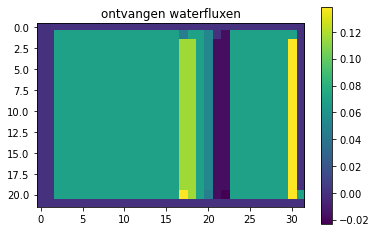

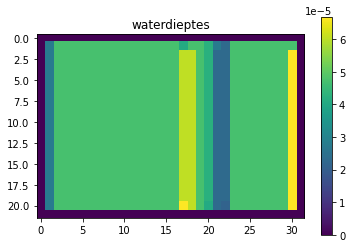

In [7]:
fluxes_flat = np.sum(fluxes_imag, axis = 0)
plt.figure()
plt.imshow(fluxes_flat)
plt.title('ontvangen waterfluxen')
plt.colorbar()

depths_imag_new[-2,-1] = 0
plt.figure()
plt.imshow(depths_imag_new)
plt.title('waterdieptes')
plt.colorbar()

Bemerk dat wanneer je de correctie van de Fluxen a.h.v. de maximale snelheid NIET toepast, dan ziet deze figuur er al realistisch uit!  

Om de code en visualisatie hierboven voorlopig te behouden, copyapste ik voorlopig het codeblok nog eens om te experimenteren met loopen in de tijd! 

In [8]:
def maak_gif(frames, filename = None):
    """
    Maakt een gif.    
    Parameters
    ----------
    frames : list
        lijst met numpy arrays van de videoframes
    filename : str, optional
        Als een bestandsnaam wordt meegegeven, wordt een gif opgeslaan van de video. De default is None.    """
    print("\nMaken van gif...")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    im = ax.imshow(frames[0])
    
    plt.tight_layout()
    
    def update_img(n):
        im.set_data(frames[n])
        return ax
    
    ani = animation.FuncAnimation(fig,update_img,len(frames))
    if isinstance(filename,str):
        if filename[-4:] != ".gif":
            filename += ".gif" 
    else: 
        filename = "goudvis.gif"
    ani.save(filename,writer='pillow',fps=30, dpi=100)
    print("Gif opgeslaan als "+filename)

In [47]:
depths_imag = np.zeros((ny+2,nx+2))
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell krijgt maximaal 4 verschillende fluxes binnen 

#initiele conservatieve initisalisatie!
deltat = 20 #[s].   #neem dus gewoon deze vaste tijdstap. 
#alle no outflow gifs werden op deltat = 20s berekend! 
#werd voor de central_neg_flux gifs op 10s gezet 

vmax_CFL = deltax/deltat
#dit laat maximale snelheid van 10 m/s of dus 36 km/u toe (lijkt me ruim genomen)
#voeg regen toe a.h.v 
in_rain = 20/(1000*3600) #in m/s
depths_imag[1:-1,1:-1] = in_rain*deltat #dus zeer weinig water om te starten!
#Dus we starten onze lus op t = deltat, omdat deze eerste arbitrate deltat nodig is om een initiële waterhoeveelheid te krijgen. 

#hier initialiseren van lijsten die tijdstappen bijhouden
depths_list = []
t_list = []
t = deltat #initialiseer de tijd
t_list.append(t)
depths_list.append(depths_imag)
theta = 0.7 #de relaxatie parameter. puur voor experimetn eens op 1 zetten
tend = 200*60  #start met animatie van één uur

#start op zeer grote deltat en laat dan aanpassen binnen de correctielus! 
deltat = 1000
vmax_CFL = deltax/deltat #deze zal dus zeer klein zijn nu, omdat deltat zo grott

n = 0.01 #cte manningscoefficient 
Acell = deltax*deltay

#SKIP
#S = slopex #gebruik altijd deze maximale slope om de snelheid te bepalen via formule van manning
#mag hier gebruikt worden omdat toch uniforme laag 
#v_mannings = 1/n*depths_imag**(2/3)*S**(1/2)
#g = 9.81 #m/s^2
#v_criticals = np.sqrt(depths_imag*g)
#vs = np.minimum(v_mannings, v_criticals) # (6) paper
#vmax = np.max(vs) #te gebruiken doorheen grid
#EINDE SKIP

from flux_calculation_NH_exp import OutfluxNH
#begin van itereren voer de verschillende cellen
depths_imag_new = np.copy(depths_imag)

deltatnews = []
while t <= tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2))
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
             #hierbij conventie volgend van Figuur 1 in onze paper
            #hoogtes
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            #dieptes
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            Ftot, deltatnew = OutfluxNH(NH_h = NH_h, NH_d = NH_d, Acell = Acell,
            deltat = deltat,deltax =  deltax, correction=True, n = n, vmax_CFL= vmax_CFL)
            deltatnews.append(deltatnew)
            #hanteer volgende regels:
            # -buur 4 krijgt flux op [0] in 3e dimensie
            # -buur 1 krijgt flux [1] in de 3e dimensie 
            # -buur 5 krijft flux [2] in de 3e dimensie
            # -buur 2 krijgt flux [3] in de 3e dimensie
            F1,F2,F4,F5 = Ftot
            F3 = -F1-F2-F4-F5
            #if any(Ftot < 0):
            #    raise Exception('Negatieve flux!')
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i+1] = F1
            fluxes_imag[2,j,i-1] = F5
            fluxes_imag[3,j+1,i] = F2
            fluxes_imag[4,j,i] = F3
    #tijd updaten: neem minimales tijdstapes uit de deltatnews! 
    deltat = np.min(np.array(deltatnews))
    vmax_CFL = deltax/deltat #belang van deze up te daten! 
    t = t + deltat
    if t % 200 < 3:
        print(t)
    t_list.append(t)
    #states updaten
    depths_imag_new = depths_imag + theta*np.sum(fluxes_imag, axis = 0)/Acell
    depths_imag = np.copy(depths_imag_new)
    
    #zorg ervoor dat de ene uitstroomcel weer leeg staat (lijkt me het meest logische, anders hier accumulatie)

    #if depths_imag[-2,-1] <= deltax*slopex:
    #    depths_imag[-2,-1] = 0
    #elif depths_imag[-2,-1] > deltax*slopex:
    #    depths_imag[-2,-1] = depths_imag[-2,-1] - deltax*slopex

    #OG was:
    #depths_imag[-2,-1] = 0

    #nu dus eens proberen ZONDER deze uitflow cel aan te passen! 
    depths_list.append(depths_imag)
    #tekst: "flow into these imaginary cells were disregarded"
    #updaten van maximale snelheden
    #gebruik de dieptes en watersurface elevation bekomen op dit punt om delta t te bepalen!
    #voeg regen toe die viel in de vorige delta t aan tijdstap
    if t < 60*60:  #regen in het 1e uur
        depths_imag[1:-1,1:-1] = depths_imag[1:-1,1:-1] + in_rain*deltat
        

4600.5982467401
4800.706563333698
5601.657860466925
6200.611551135438


c:\Users\olivi\OneDrive - UGent\Bio-ingenieur master 2021-2022\semester 2\Spatio temporal models\Project_Spatio_Temporele_2\Project_Spatio_Temporele_2\flux_calculation_NH_exp.py:79: RuntimeWarning: invalid value encountered in double_scalars
  vmin1 = 1/n*R**(2/3)*S**(1/2)


7600.338715632518
8200.35566722867
8601.36437663921
9000.322519841755
10800.19783257491
11000.360053076012


..............................................................

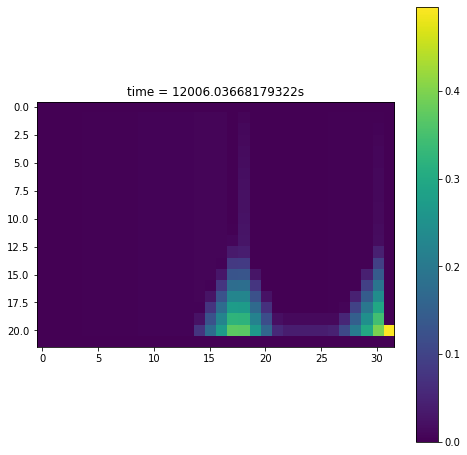

In [48]:
#snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]
fps = 10
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))
a = depths_list[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:])) #cmap = 'Greys'
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('deltat1000start.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])
#video = anim.to_html5_video()
# embedding for the video
#html = display.HTML(video)
  
# draw the animation
#display.display(html)

In [38]:
print(deltat)
print(t_list)

500


In [11]:
def gif_maken_bis(layers, tijdstappen, fps, naam_file):
    fig, ax = plt.subplots(figsize = (8,8))
    a = depths_list[0]
    im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:]))
    plt.colorbar(im)


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(layers[i])
        ax.set_title('time = '+str(tijdstappen[i]) + 's')
    
        return [im]

    anim = animation.FuncAnimation(fig, animate_func, frames = len(layers), interval = 1000 / fps) # in ms)
    anim.save(naam_file+'.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])        
    print("Gif opgeslaan als "+naam_file)

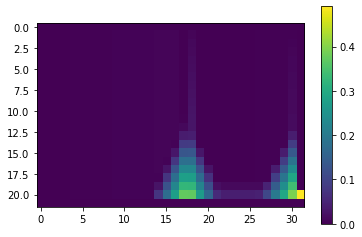

In [33]:
plt.imshow(depths_list[-1])
plt.colorbar()

Veronderstelling die ik maak: voeg op $t + \Delta t$ de regen toe die viel tussen $t$ en $t + \Delta t$. Door dit uniform toe te voegen aan de dieptes van de vorige tijdstap, bekom ik een nieuwe diepte. Deze 

In [13]:
#for i in np.arange(0,len(depths_list),20):
#    plt.figure()
#    plt.imshow(depths_list[i])
#    plt.colorbar()
#    plt.show()
#    plt.close()

In [14]:
in_rain

5.555555555555556e-06

SKIP DIT HIERONDER: IS NIET VAN BELANG! 
Eens proberen om een uniforme laag water te doen weglopen

In [15]:
#uniform een laag water, dit laten weglopen
depths_imag = np.zeros((ny+2,nx+2))
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell krijgt maximaal 4 verschillende fluxes binnen 

#initiele conservatieve initisalisatie!
deltat = 10 #[s].   #neem dus gewoon deze vaste tijdstap
vmax_CFL = deltax/deltat
#dit laat maximale snelheid van 10 m/s of dus 36 km/u toe (lijkt me ruim genomen)
#voeg regen toe a.h.v 
in_rain = 20/(1000*3600) #in m/s
depths_imag[1:-1,1:-1] = 20/1000 #dus nieuw idee: start eens van de volle laag! 
#hier initialiseren van lijsten die tijdstappen bijhouden
depths_list = []
t_list = []
t = deltat #initialiseer de tijd
t_list.append(t)
depths_list.append(depths_imag)
theta = 0.7 #de relaxatie parameter
tend = 60*60  #start met animatie van één uur
n = 0.01 #cte manningscoefficient 

from flux_calculation_NH import OutfluxNH
#begin van itereren voer de verschillende cellen
depths_imag_new = np.copy(depths_imag)

while t <= tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2))
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
             #hierbij conventie volgend van Figuur 1 in onze paper
            #hoogtes
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            #dieptes
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            Ftot = OutfluxNH(NH_h = NH_h, NH_d = NH_d, Acell = Acell,
            deltat = deltat,deltax =  deltax, correction=False, n = n)
            #hanteer volgende regels:
            # -buur 4 krijgt flux op [0] in 3e dimensie
            # -buur 1 krijgt flux [1] in de 3e dimensie 
            # -buur 5 krijft flux [2] in de 3e dimensie
            # -buur 2 krijgt flux [3] in de 3e dimensie
            F1,F2,F4,F5 = Ftot
            F3 = -F1-F2-F4-F5
            #if any(Ftot < 0):
            #    raise Exception('Negatieve flux!')
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i+1] = F1
            fluxes_imag[2,j,i-1] = F5
            fluxes_imag[3,j+1,i] = F2
    #tijd updaten
    t = t + deltat
    if t % 200 == 0:
        print(t)
    t_list.append(t)
    #states updaten
    depths_imag_new = depths_imag + theta*np.sum(fluxes_imag, axis = 0)/Acell
    depths_imag = np.copy(depths_imag_new)
    
    #zorg ervoor dat de ene uitstroomcel weer leeg staat (lijkt me het meest logische, anders hier accumulatie)
    depths_imag[-2,-1] = 0
    depths_list.append(depths_imag)

    #updaten van maximale snelheden
    #gebruik de dieptes en watersurface elevation bekomen op dit punt om delta t te bepalen!
    #voeg regen toe die viel in de vorige delta t aan tijdstap
    #if t < 60*60:  #regen in het 1e uur
    #    depths_imag[1:-1,1:-1] = depths_imag[1:-1,1:-1] + in_rain*deltat
        

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600


....................

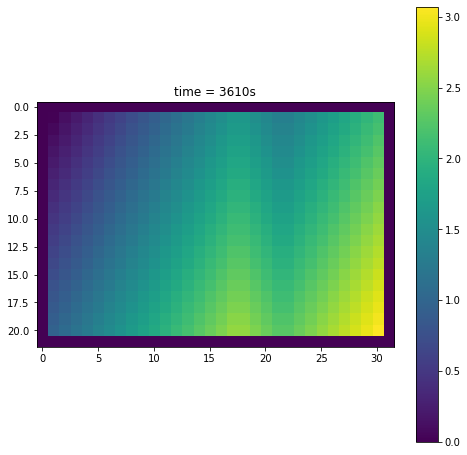

In [16]:
fps = 20
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('runoff_begin_all.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])